<a href="https://colab.research.google.com/github/yahui624/DeployTFModels-FL/blob/main/deployModel_TFServing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import json 
import requests 
import numpy as np
from pathlib import Path
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow_serving.apis.predict_pb2 import PredictRequest

2022-12-02 00:06:27.363420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(X_train.shape)
print(X_train.dtype)

(55000, 28, 28)
uint8


In [4]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

2022-12-02 00:07:07.586159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.layers

In [9]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()

dense
True


In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7026 - accuracy: 0.7708 - val_loss: 0.5009 - val_accuracy: 0.8278
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4846 - accuracy: 0.8324 - val_loss: 0.4490 - val_accuracy: 0.8446
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4418 - accuracy: 0.8463 - val_loss: 0.4550 - val_accuracy: 0.8362
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4143 - accuracy: 0.8547 - val_loss: 0.4000 - val_accuracy: 0.8608
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3945 - accuracy: 0.8621 - val_loss: 0.3890 - val_accuracy: 0.8630
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3776 - accuracy: 0.8671 - val_loss: 0.3900 - val_accuracy: 0.8556
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3639 - accuracy: 0.8716 - val_loss: 0.3750 - val_accuracy:

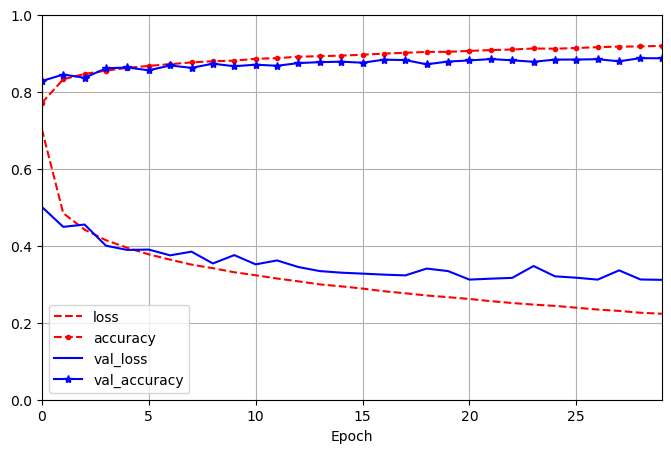

In [14]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [16]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3346 - accuracy: 0.8826


[0.3345809280872345, 0.8826000094413757]

In [76]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 79ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [18]:
y_pred = y_proba.argmax(axis=-1)
print(y_pred)
print(np.array(class_names)[y_pred])

[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


In [19]:
y_new = y_test[:3]
print(y_new)

[9 2 1]


In [42]:
# Exporting SavedModels
model_name = "my_mnist_model"
model_version = "0001"
model_path = Path(model_name) / model_version
# model.save(model_path, save_format="tf")
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: my_mnist_model/0001/assets


INFO:tensorflow:Assets written to: my_mnist_model/0001/assets


In [40]:
import shutil
shutil.rmtree( model_name )

In [46]:
loaded = tf.saved_model.load(model_path)
y_pred = loaded(tf.constant(X_new, dtype=tf.float32))
print(y_pred)

tf.Tensor(
[[2.96729240e-06 3.24253790e-07 4.11663768e-06 7.27072256e-06
  1.29482646e-06 2.42043776e-03 7.36846960e-06 1.15544340e-02
  1.17851116e-04 9.85883892e-01]
 [4.25754261e-05 1.95856553e-09 9.99161482e-01 5.88559734e-09
  7.75854627e-04 1.26225502e-10 2.01291659e-05 3.30601770e-14
  2.91620594e-09 6.63436374e-13]
 [3.43607098e-06 9.99995828e-01 3.03607628e-09 4.08202112e-07
  3.23290408e-07 4.41865424e-12 2.92902111e-08 6.11560733e-11
  2.98311154e-09 2.53083804e-11]], shape=(3, 10), dtype=float32)


In [47]:
infer = loaded.signatures["serving_default"]
print(list(loaded.signatures.keys()))  # ["serving_default"]
print(infer.structured_outputs)

['serving_default']
{'dense_2': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_2')}


In [48]:
!saved_model_cli show --dir my_mnist_model/0001

2022-12-02 00:41:22.007917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
The given SavedModel contains the following tag-sets:
'serve'


In [49]:
!saved_model_cli show --dir my_mnist_model/0001 --tag_set serve

2022-12-02 00:41:28.823007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [50]:
! saved_model_cli show --dir my_mnist_model/0001 --tag_set serve --signature_def serving_default

2022-12-02 00:41:35.391054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28)
      name: serving_default_flatten_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [51]:
!saved_model_cli show --dir {model_path} --all # saved model 

2022-12-02 00:41:39.916681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['flatten_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: serving_default_flatten_input:0
  The given SavedMo

If running locally, needs to use docker docker run -it --rm -v  "/Users/yzhao/Documents/Fall22/ML/DeployTFModels-FL/my_mnist_model:/models/my_mnist_model" -p 8500:8500 -p 8501:8501 -e MODEL_NAME=my_mnist_model tensorflow/serving 

In [53]:
np.save( "my_mnist_tests.npy", X_new )
os.environ["MODEL_DIR"] = str(model_path.parent.absolute())
print(str(model_path.parent.absolute()))

/Users/yzhao/Documents/Fall22/ML/DeployTFModels-FL/my_mnist_model


In [54]:
!saved_model_cli run --dir {model_path} --tag_set serve \
                     --signature_def serving_default    \
                     --inputs {input_name}=my_mnist_tests.npy

2022-12-02 00:43:24.000873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 00:43:27.606600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.saved_model.load` instead.
INFO:tensorflow:Restoring parameters from my_mnist_model/0001/variables/variables
2022-12-02 00:43:27.870032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
Result for output key dense_2:
[[2.9672

In [33]:
%%bash --bg
tensorflow_model_server \
     --port=8500 \
     --rest_api_port=8501 \
     --model_name=my_mnist_model \
     --model_base_path="${MODEL_DIR}" >my_server.log 2>&1

In [59]:
!docker pull tensorflow/serving
!docker run -it --rm -p 8500:8500 -p 8501:8501 \
   -v "/Users/yzhao/Documents/Fall22/ML/DeployTFModels-FL/my_mnist_model:/models/my_mnist_model" \
   -e MODEL_NAME=my_mnist_model \
   tensorflow/serving

Using default tag: latest
latest: Pulling from tensorflow/serving
Digest: sha256:e66c1866bf6596473d56beb3ef77bf7b8b00baa0e1e80c3c428ede31da8ae066
Status: Image is up to date for tensorflow/serving:latest
docker.io/tensorflow/serving:latest
2022-12-02 08:54:22.076963: I tensorflow_serving/model_servers/server.cc:74] Building single TensorFlow model file config:  model_name: my_mnist_model model_base_path: /models/my_mnist_model
2022-12-02 08:54:22.080271: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2022-12-02 08:54:22.080412: I tensorflow_serving/model_servers/server_core.cc:594]  (Re-)adding model: my_mnist_model
2022-12-02 08:54:22.316537: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: my_mnist_model version: 1}
2022-12-02 08:54:22.316607: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: my_mnist_model version: 1}
2022-12-02 08:54:22.316648: I tensorflo

In [72]:
# Query TF serving 
request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist(),
})
# POST REST request to TF Serving
server_url = "http://localhost:8501/v1/models/my_mnist_model:predict"
response = requests.post(server_url, data=request_json)
response.raise_for_status()  # raise an exception in case of error
response = response.json()
print(response)

{'predictions': [[2.96729536e-06, 3.2425379e-07, 4.11664541e-06, 7.27073666e-06, 1.29482646e-06, 0.00242043892, 7.36847642e-06, 0.0115544396, 0.000117851232, 0.985883892], [4.25755061e-05, 1.95856553e-09, 0.999161482, 5.88558624e-09, 0.000775854627, 1.26225502e-10, 2.01292041e-05, 3.30602414e-14, 2.91620594e-09, 6.63435127e-13], [3.43606439e-06, 0.999995828, 3.03607051e-09, 4.08200947e-07, 3.23289783e-07, 4.418646e-12, 2.92901543e-08, 6.11559622e-11, 2.98310576e-09, 2.53083318e-11]]}


In [66]:
y_proba = np.array( response['predictions'] )
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])